# Classifying Risks Leveraging Poisson Regression Model

- The frequency of claim is the target variable here.
- Minimal risk rating factor that can be leveraged to classify risks into frequency bands will be a good outcome to nail down
- Make the model an inference service that can bedeployed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

## But First, Shall We Prepare the Dataset 

- Claims data includes yearly totals and breakdowns by claim type.
- Aggregate the claims data to obtain the claims frequency unique to each ID and year
- Merge result with rating factors on (ID, year).
- Assign a frequency of 0 to policies with no recorded claims.

In [2]:
rating_factors = pd.read_csv('../data/input/exp/Motor vehicle insurance data.csv', delimiter=";")
claims =  pd.read_csv('../data/input/exp/sample type claim.csv', delimiter=';')

In [3]:
claims_frequency  = (
    claims
    .groupby(['ID', 'Cost_claims_year'])
    .agg({
        'Cost_claims_by_type': 'count'})
    .rename(columns={'Cost_claims_by_type': 'claims_frequency'})
    .reset_index()
)

In [4]:
dataset = (
    pd.merge(
        left=rating_factors,
        right=claims_frequency,
        how='left',
        on=['ID', 'Cost_claims_year']
    )
)
dataset.describe()

,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,claims_frequency
count,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,...,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,95226.000000,105555.000000,5258.000000
mean,26271.286789,0.451310,6.696604,1.455649,1.837232,1.065842,0.221837,0.319180,315.892557,153.557305,...,0.273895,0.123708,2004.728038,92.682611,1617.759367,18413.657243,4.067898,4.252007,1191.262422,1.401483
std,15388.309324,0.497626,6.263911,0.928427,1.155536,0.267807,0.464858,0.466161,140.927969,1477.112362,...,0.445958,0.329250,6.767037,37.012645,604.697382,9135.074235,1.511839,0.393220,458.081834,0.750559
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,40.140000,0.000000,...,0.000000,0.000000,1950.000000,0.000000,49.000000,270.460000,0.000000,1.978000,43.000000,1.000000
25%,12925.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,241.610000,0.000000,...,0.000000,0.000000,2001.000000,75.000000,1390.000000,13127.210000,3.000000,3.999000,1043.000000,1.000000
50%,26082.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.000000,292.280000,0.000000,...,0.000000,0.000000,2005.000000,90.000000,1598.000000,17608.770000,5.000000,4.230000,1205.000000,1.000000
75%,39754.000000,1.000000,9.000000,2.000000,2.000000,1.000000,0.000000,1.000000,361.640000,0.000000,...,1.000000,0.000000,2008.000000,110.000000,1910.000000,22595.000000,5.000000,4.443000,1388.000000,2.000000
max,53502.000000,1.000000,40.000000,17.000000,17.000000,4.000000,7.000000,1.000000,2993.340000,260853.240000,...,1.000000,1.000000,2018.000000,580.000000,7480.000000,220675.800000,6.000000,8.218000,7300.000000,9.000000


## Claims rate per unit exposure
- The data is structured such that each record is policy that runs for a year, as such let's calculate the claims rate per unit exposure (policy length)
- Creating matrix a using - Age, driving lenght, insurable object type (e.g van, motorcycle etc.)
    - Age banded into 3 levels of 0-35, 36-70, >70 as 0,1,2
    - Driving length banded into 2 levels of less than 5 years of experience and greater than 5 years experience as 0,1
    - Type risk has levels 1,2,3,4 representing motorbikes, van, passengers and agricultural vehicles respectively

In [5]:
rating_factors = (
    dataset
    .copy()[['Date_driving_licence','Date_birth','Type_risk', 'claims_frequency','Cost_claims_year']]
    .fillna({'Date_driving_licence': pd.NaT,  'claims_frequency': 0})
    .assign(age_band=lambda x: pd.cut((pd.Timestamp.now() - pd.to_datetime(x['Date_birth'], dayfirst=True)).dt.days // 365, 
                                 bins=[0, 35, 70, float('inf')], 
                                 labels=[0, 1, 2], 
                                 include_lowest=True).astype(int))
    .assign(driving_length=lambda x:((pd.Timestamp.now() - pd.to_datetime(x['Date_driving_licence'], dayfirst=True)).dt.days // 365 >= 5).astype(int))
    .drop(columns=['Date_driving_licence', 'Date_birth'], axis=1)
    .assign(intercept=1)
)
rating_factors

,Type_risk,claims_frequency,Cost_claims_year,age_band,driving_length,intercept
0,1,0.0,0.0,1,1,1
1,1,0.0,0.0,1,1,1
2,1,0.0,0.0,1,1,1
3,1,0.0,0.0,1,1,1
4,1,0.0,0.0,1,1,1
...,...,...,...,...,...,...
105550,3,0.0,0.0,1,1,1
105551,3,0.0,0.0,1,1,1
105552,3,0.0,0.0,1,1,1
105553,2,0.0,0.0,2,1,1


In [6]:
rating_factors_matrix = (
    rating_factors
    .groupby(['age_band', 'driving_length', 'Type_risk'])
    .agg({'claims_frequency':'sum', 'Cost_claims_year':'sum'})
    .assign(claims_rate_per_unit_exposure=lambda x:(x['claims_frequency']/x['Cost_claims_year']))
    .reset_index()
    .fillna({'claims_rate_per_unit_exposure':0})
)
rating_factors_matrix

,age_band,driving_length,Type_risk,claims_frequency,Cost_claims_year,claims_rate_per_unit_exposure
0,0,1,1,27.0,51431.88,0.000525
1,0,1,2,24.0,49850.71,0.000481
2,0,1,3,496.0,1423505.43,0.000348
3,0,1,4,0.0,0.00,0.000000
4,1,1,1,209.0,224939.07,0.000929
5,1,1,2,822.0,1917519.21,0.000429
6,1,1,3,5111.0,11103401.38,0.000460
7,1,1,4,0.0,192.67,0.000000
8,2,1,1,16.0,32685.29,0.000490
9,2,1,2,141.0,230383.40,0.000612


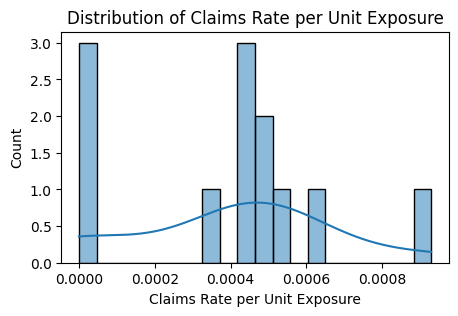

In [7]:
plt.figure(figsize=(5, 3))
sns.histplot(data=rating_factors_matrix, x='claims_rate_per_unit_exposure', bins=20, kde=True)
plt.title('Distribution of Claims Rate per Unit Exposure')
plt.xlabel('Claims Rate per Unit Exposure')
plt.ylabel('Count')
plt.show()


## Poisson Model - Shall we fit one?

In [8]:
train_dev, test = train_test_split(rating_factors, test_size=0.2, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.2, random_state=42)

print(f"Train set size: {len(train)}")
print(f"Dev set size: {len(dev)}")
print(f"Test set size: {len(test)}")
print(f"Total: {len(train) + len(dev) + len(test)}")

Train set size: 67555
Dev set size: 16889
Test set size: 21111
Total: 105555


In [9]:
X = train_dev[['Type_risk', 'age_band', 'driving_length', 'intercept']]
y = train_dev[['claims_frequency']]

In [10]:
X

,Type_risk,age_band,driving_length,intercept
72716,2,1,1,1
95053,2,1,1,1
98446,3,1,1,1
41836,3,1,1,1
16050,3,1,1,1
...,...,...,...,...
54886,3,1,1,1
76820,3,1,1,1
103694,3,1,1,1
860,3,2,1,1


In [11]:
fit = sm.GLM(
    y,
    X, #[['intercept', 'Type_risk', 'age_band']],
    # offset=np.log(X['intercept']),
    family=sm.families.Poisson()
)
model = fit.fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       claims_frequency   No. Observations:                84444
Model:                            GLM   Df Residuals:                    84441
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23030.
Date:                Fri, 04 Jul 2025   Deviance:                       36666.
Time:                        23:59:29   Pearson chi2:                 1.43e+05
No. Iterations:                   100   Pseudo R-squ. (CS):           0.001793
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Type_risk          0.0733      0.029      2.

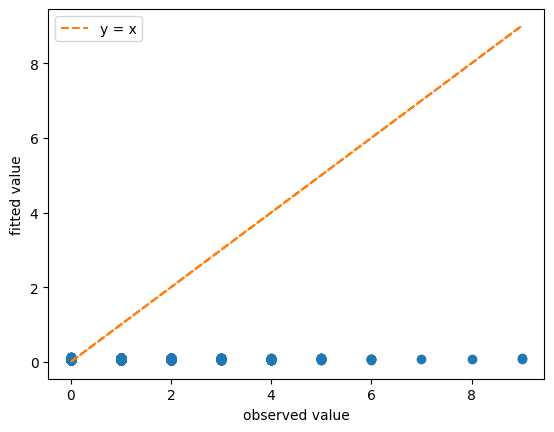

In [12]:
plt.plot(y, model.fittedvalues, 'o')
plt.plot(y, y, '--', label='y = x')
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()